In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
sys.path.insert(0, os.path.abspath('..'))
from arrival_model.Environments.ArrivalCar.CarDynamics import CarDynamics

dynamics = CarDynamics()


class ArrivalCarVisualizer:
    def __init__(self, waiting_for_show=10):
        self.waiting_for_show = waiting_for_show
        self.total_rewards = []
        self.noise_thresholds = []
        self.actions = []
        self.session = None
        
    def show_fig(self, env, agent, sessions):
        
        plt.figure(figsize=[18, 18])
        plt.subplot(331)
        
        for session in sessions:
            plt.plot(session['info'][-1]['xs'], session['info'][-1]['ys'], 'g', label='trajectory')
        alpha = np.linspace(0, 2 * np.pi, 50)
        plt.plot(20 * np.sin(alpha), 20 * np.cos(alpha), 'r')
        plt.xlim((-30, 30))
        plt.ylim((-30, 30))
        plt.title('trajectory')
        plt.grid()

        plt.subplot(332)
        for session in sessions:
            actions = np.array(session['actions'])
            plt.plot(actions[:, 0], 'g', label='actions')
        plt.title('actions[0]')
        plt.grid()
        
        plt.subplot(333)
        for session in sessions:
            actions = np.array(session['actions'])
            plt.plot(actions[:, 1], 'g', label='actions')
        plt.title('actions[1]')
        plt.grid()
        
        plt.subplot(334)
        mean_total_rewards = np.mean(self.total_rewards[-20:])
        label = f'total_rewards: \n current={self.total_rewards[-1]:.2f} \n mean={mean_total_rewards:.2f}'
        plt.plot(self.total_rewards, 'g', label=label)
        plt.title('mean_total_rewards')
        plt.grid()
        
        plt.subplot(335)
        for session in sessions:
            states = np.array(session['states'])
            actions = np.array(session['actions'])
            plt.plot(states[:, 2], 'g', label='yaw rate')
            vs = np.sqrt(states[:, 0] ** 2 + states[:, 1] **2)
            vs = vs[:-1]
            plt.plot(actions[:, 1] * vs / dynamics.param.VehPrmVehWhlBas, 'r', label='r')
        plt.title('yaw rate')
        plt.grid()
        
        plt.subplot(336)
        for session in sessions:
            states = np.array(session['states'])
            plt.plot(np.sqrt(states[:, 0] ** 2 + states[:, 1] ** 2), 'g', label='speed')
        plt.title('speed')
        plt.grid()
        
        clear_output(True)
        plt.show()
        
        return None
        
    def show(self, env, agent, episode, sessions):
        total_reward = np.mean([sum(session['rewards']) for session in sessions])
        self.total_rewards.append(total_reward)
        self.noise_thresholds.append(agent.noise.threshold)
        
        if episode % self.waiting_for_show == 0:
            self.session = sessions[-1]
            self.show_fig(env, agent, sessions)
        return None
            
    def clean(self):
        self.total_rewards = []
        self.noise_thresholds = []
        return None

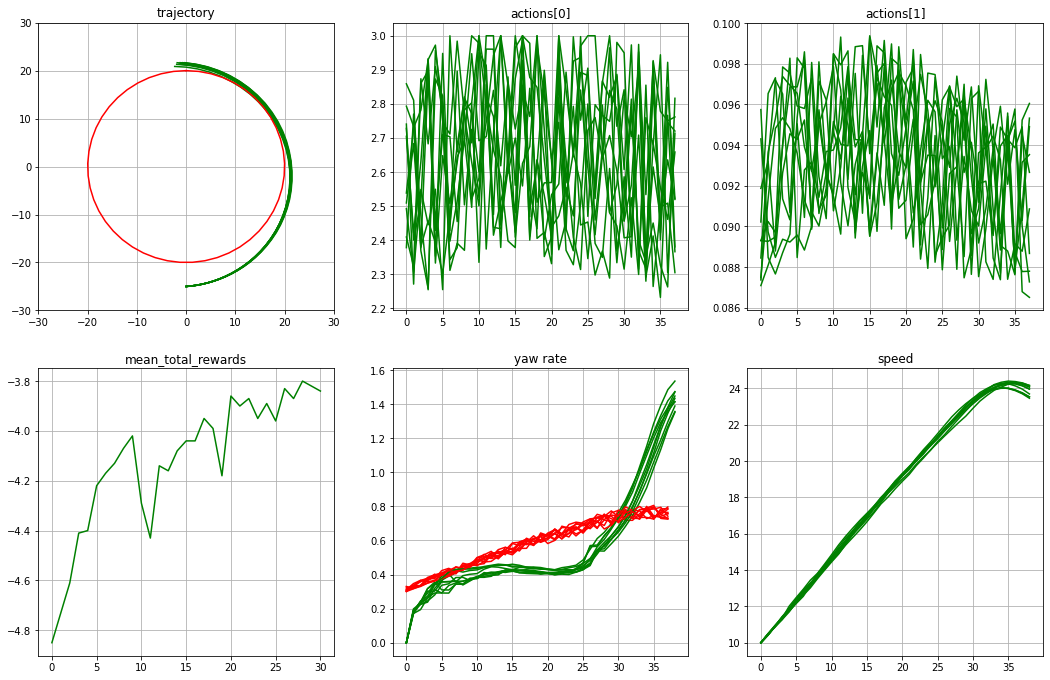

KeyboardInterrupt: 

In [3]:
import time
import numpy as np
import torch.nn as nn
from Agents.CCEM import CCEM
from Agents.Utilities.SequentialNetwork import SequentialNetwork
from Agents.Utilities.Noises import UniformNoise
from Solvers import OneAgentSolver as solver
from Environments.ArrivalCar.ArrivalCarCircle import ArrivalCarCircle
%load_ext autoreload
%autoreload 2

episode_n = 40

#initial state
init_car_speed = 10
initial_state=np.array([init_car_speed, 0, 0, 0, 0,
                        init_car_speed/0.312*30/np.pi*1e-3,
                        init_car_speed/0.312*30/np.pi*1e-3,
                        init_car_speed/0.350*30/np.pi*1e-3,
                        init_car_speed/0.350*30/np.pi*1e-3])

#environment
env = ArrivalCarCircle(initial_state=initial_state, dt=0.1, inner_dt=0.05)
env.action_min = np.array([0, np.pi/50])
env.action_max = np.array([3, np.pi/30])

#agent
pi_model = SequentialNetwork([env.state_dim, 128, env.action_dim], nn.ReLU(), nn.Tanh())
noise = UniformNoise(env.action_dim, threshold_decrease=1/episode_n)
agent = CCEM(env.state_dim, env.action_dim, env.action_min, env.action_max, pi_model, noise, 
             percentile_param=80, tau=1e-2, pi_model_lr=1e-2, learning_iter_per_fit=16)

#learning
start_time = time.time()
visualizer = ArrivalCarVisualizer(waiting_for_show=1)
solver.go(env, agent, episode_n=episode_n, session_n=10, session_len=101, show=visualizer.show)
print(f'time: {(time.time() - start_time) / 60}')

In [7]:
np.pi/30 * 180 / np.pi

6.0

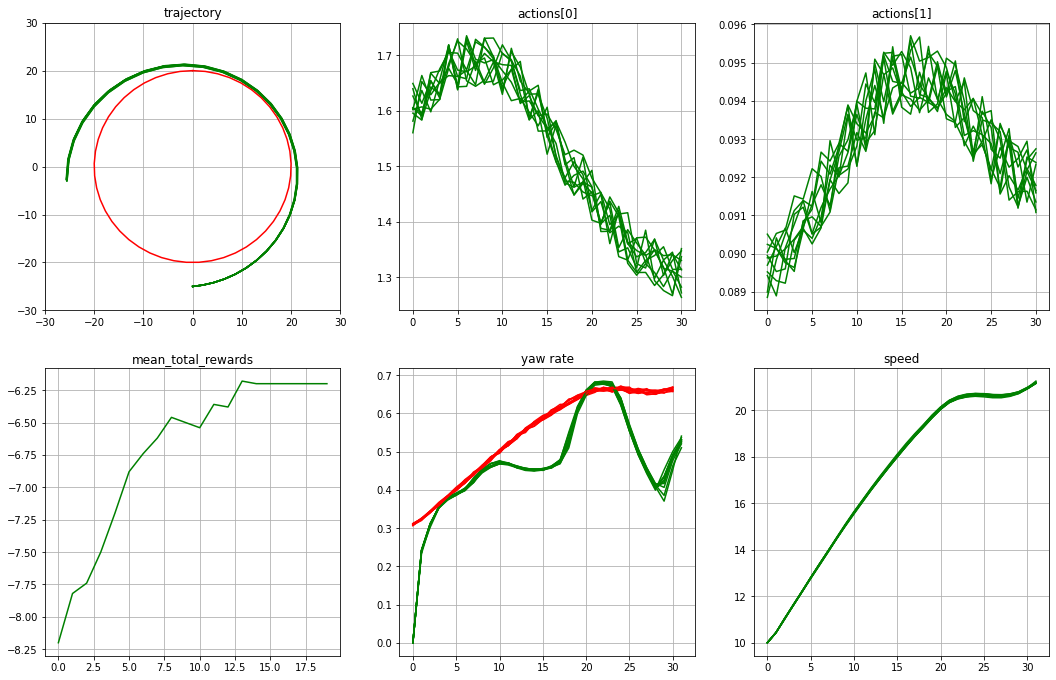

time: 1628401452.6113265


In [6]:
import time
import numpy as np
import torch.nn as nn
from Agents.CCEM import CCEM
from Agents.Utilities.SequentialNetwork import SequentialNetwork
from Agents.Utilities.Noises import UniformNoise
from Solvers import OneAgentSolver as solver
from Environments.ArrivalCar.ArrivalCarCircle import ArrivalCarCircle
%load_ext autoreload
%autoreload 2

episode_n = 20

#define initial state
init_car_speed = 10
initial_state=np.array([init_car_speed, 0, 0, 0, 0,
                        init_car_speed/0.312*30/np.pi*1e-3,
                        init_car_speed/0.312*30/np.pi*1e-3,
                        init_car_speed/0.350*30/np.pi*1e-3,
                        init_car_speed/0.350*30/np.pi*1e-3])
#init_state = np.array([init_car_speed, 0, 0, 0, 0, init_wheel_speed, init_wheel_speed, init_wheel_speed, init_wheel_speed])

env = ArrivalCarCircle(initial_state=initial_state, dt=0.2, inner_dt=0.05, circle_part=3/4)
env.action_min = np.array([0, np.pi/50])
env.action_max = np.array([2, np.pi/30])

pi_model = SequentialNetwork([env.state_dim, 128, env.action_dim], nn.ReLU(), nn.Tanh())
noise = UniformNoise(env.action_dim, threshold_decrease=1/episode_n)
agent = CCEM(env.state_dim, env.action_dim, env.action_min, env.action_max, pi_model, noise, 
             percentile_param=80, tau=1e-2, pi_model_lr=1e-2, learning_iter_per_fit=16)

start_time = time.time()
visualizer = ArrivalCarVisualizer(waiting_for_show=1)
solver.go(env, agent, episode_n=episode_n, session_n=10, session_len=101, show=visualizer.show)
print(f'time: {(time.time() - start_time / 60)}')

In [8]:
np.pi/30

0.10471975511965977

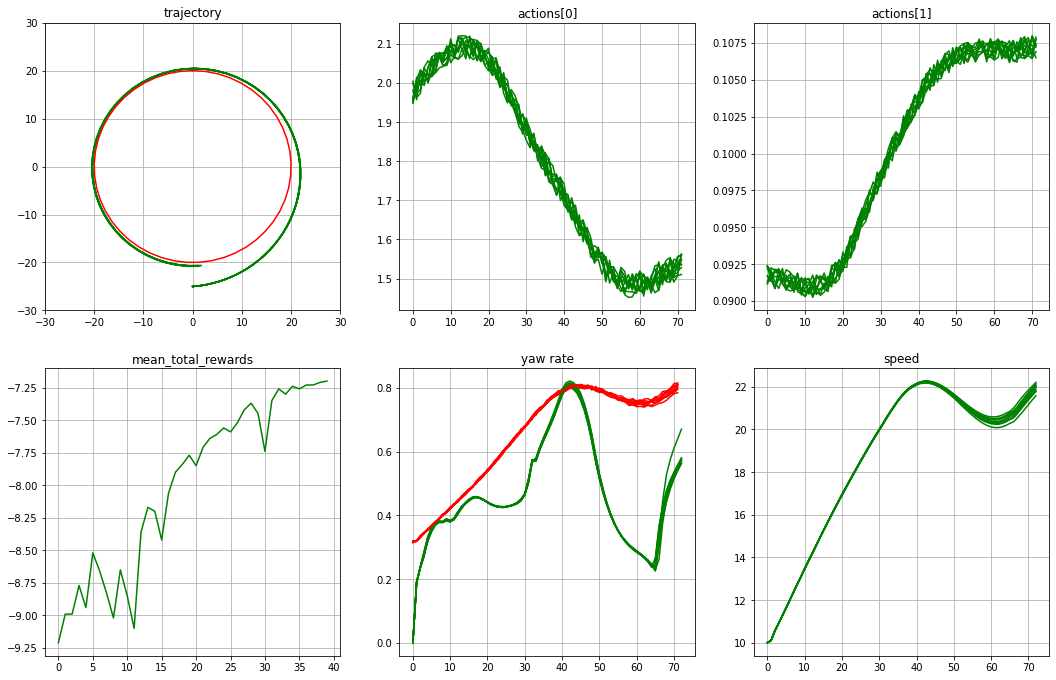

time: 31.713626730442048


In [17]:
import time
import numpy as np
import torch.nn as nn
from Agents.CCEM import CCEM
from Agents.Utilities.SequentialNetwork import SequentialNetwork
from Agents.Utilities.Noises import UniformNoise
from Solvers import OneAgentSolver as solver
from Environments.ArrivalCar.ArrivalCarCircle import ArrivalCarCircle
%load_ext autoreload
%autoreload 2

episode_n = 40

#define initial state
init_car_speed = 10
initial_state=np.array([init_car_speed, 0, 0, 0, 0,
                        init_car_speed/0.312*30/np.pi*1e-3,
                        init_car_speed/0.312*30/np.pi*1e-3,
                        init_car_speed/0.350*30/np.pi*1e-3,
                        init_car_speed/0.350*30/np.pi*1e-3])
#init_state = np.array([init_car_speed, 0, 0, 0, 0, init_wheel_speed, init_wheel_speed, init_wheel_speed, init_wheel_speed])

env = ArrivalCarCircle(initial_state=initial_state, dt=0.1, inner_dt=0.05, circle_part=1)
env.action_min = np.array([0, np.pi/50])
env.action_max = np.array([2.5, np.pi/25])

pi_model = SequentialNetwork([env.state_dim, 128, env.action_dim], nn.ReLU(), nn.Tanh())
noise = UniformNoise(env.action_dim, threshold_decrease=1/episode_n)
agent = CCEM(env.state_dim, env.action_dim, env.action_min, env.action_max, pi_model, noise, 
             percentile_param=80, tau=1e-2, pi_model_lr=1e-2, learning_iter_per_fit=16)

start_time = time.time()
visualizer = ArrivalCarVisualizer(waiting_for_show=1)
solver.go(env, agent, episode_n=episode_n, session_n=10, session_len=101, show=visualizer.show)
print(f'time: {(time.time() - start_time) / 60}')